In [1]:
from joblib import load

import numpy as np
from sklearn.metrics import (mean_squared_error as mse,
                             mean_squared_log_error as msle,
                             mean_absolute_error as mae,
                             r2_score)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from load_transform import load_transform_dataset
from features import compute_feature_vectors
from plot_utils import plot_regressor_output
from custom_metrics import preciness
from assignment_utils import split_dataset, get_X_y


from IPython.display import display, HTML, Image

sns.set_style('whitegrid')

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 125

## Business Goal / Metrics
---
Apart from low level metrics, like **rmse** and **rmsle**, that are useful as first steps for evaluating our training approach and model decisions, we need to further evaluate our model/algorithm as whole on the given business task and understand how helpful it can be. 

In this case we are interested in ordering the users of a given month, for which we have no access to their transaction amounts, based on their predicted income and expenses amount. This ordering will be used from our marketing department that wants to target people in specific ranges of income/expenses. They will be happy if they know that when targeting bulks of 100 customers at least x percentage of them are in the correct group.

As a proxy to this we will measure the percentage of times our ordering results are less or equal to 50 positions away from the correct ordering. I will call this metric `ordering_precision`. We should look at how biases of the model affect this metric. 

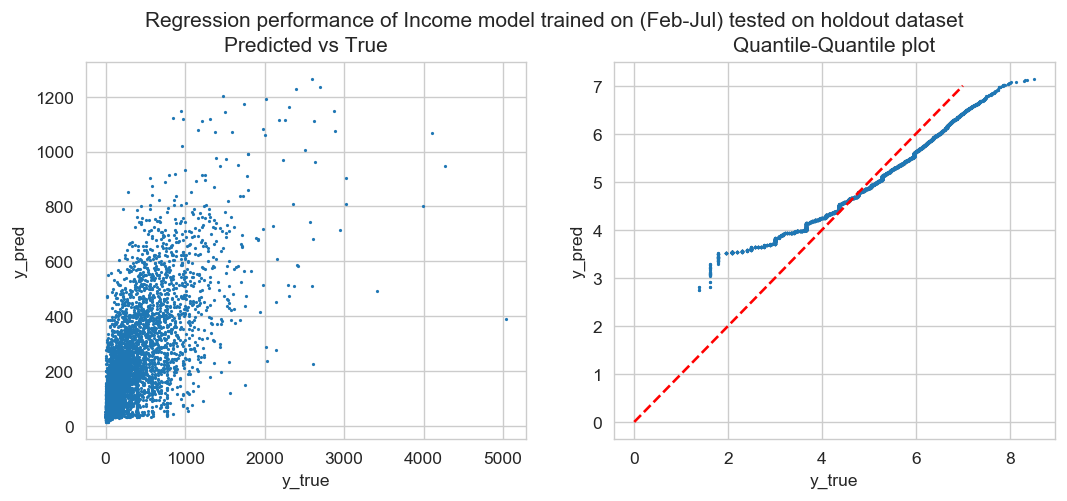

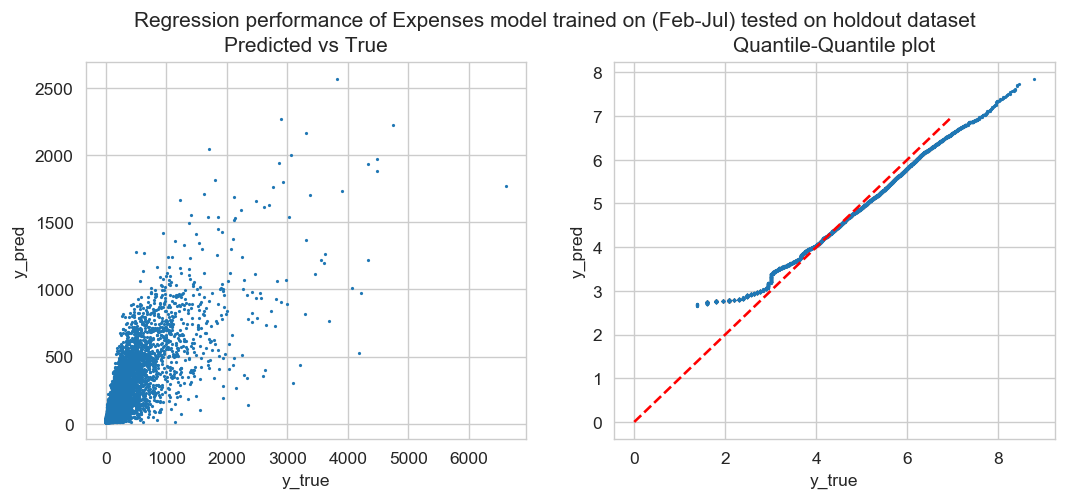

Income 	model 		rmse 	306.2202
Expenses 	model 	rmse 	283.7307
Income 	model 		rmsle 	0.9398
Expenses 	model 	rmsle 	0.749
Income 	model 		r2 	0.3736
Expenses 	model 	r2 	0.5563
Income 	model 		preciseness 	0.1855
Expenses 	model 	preciseness 	0.2133
Ordering precisiness of Income model 0.10568513119533528


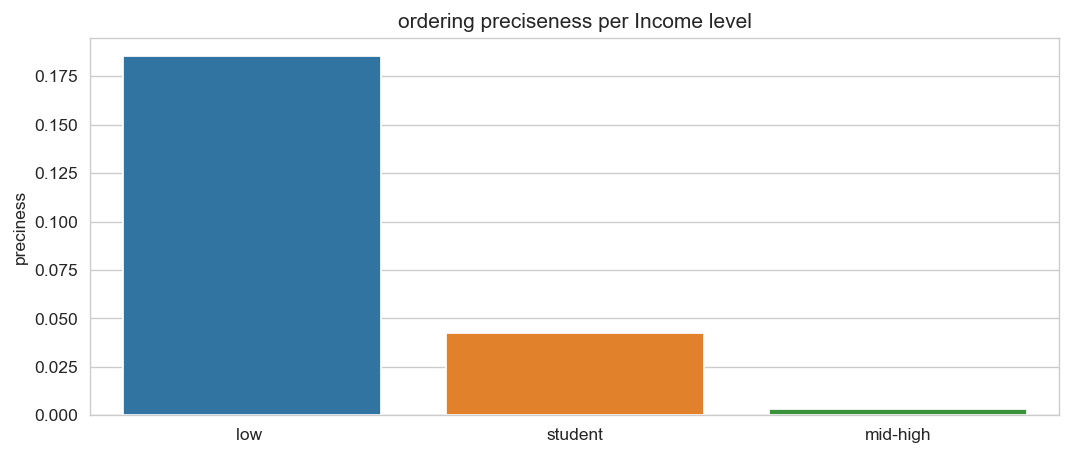

Ordering precisiness of Expenses model 0.11247086247086246


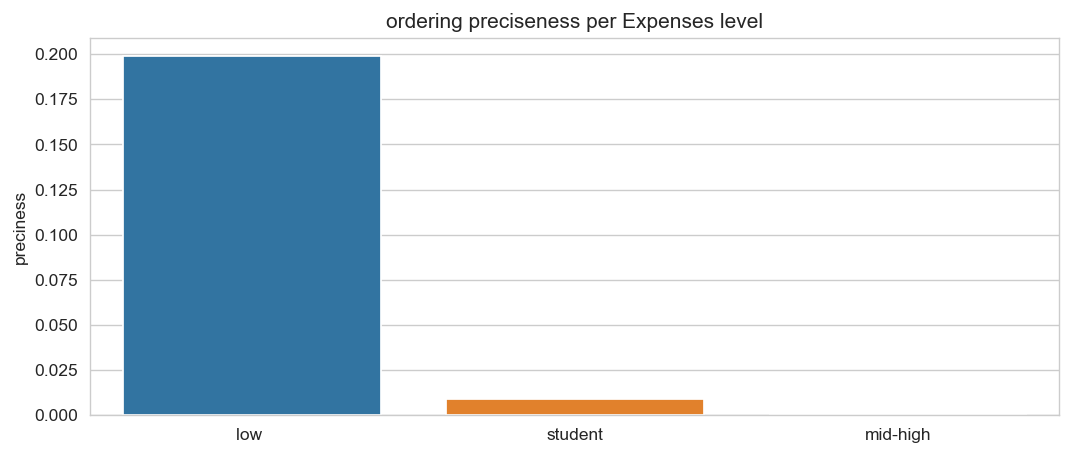

In [61]:
in_model = load('income_model.joblib')
exp_model = load('expenses_model.joblib')


rmse = lambda y_t, y_p: np.sqrt(mse(y_t, y_p))
rmsle = lambda y_t, y_p: np.sqrt(msle(y_t, y_p))


def evaluate_algorithm(in_model, exp_model, holdout_ds, month=None):
    ds, user_finances = load_transform_dataset(holdout_ds)
    
    if month:
        user_finances = user_finances[user_finances.month == month]

    feature_vectors, _ = compute_feature_vectors(ds)
    
    # we filter out any 0 income/expenses user. For those users we can be sure they had 0 income/expenses
    # by the fact that there was no relevant transaction during the month we care about
    ds_in, ds_out = user_finances[user_finances['in'] != 0], user_finances[user_finances['out'] != 0]

    X_in, y_in = get_X_y(ds_in, feature_vectors, 'in')
    X_out, y_out = get_X_y(ds_out, feature_vectors, 'out')

    y_pred_in = in_model.predict(X_in)
    y_pred_out = exp_model.predict(X_out)
    
    # sanity checking that our model never predicts negative balances
    assert np.min(y_pred_in) >= 0
    assert np.min(y_pred_out) >= 0

    plot_regressor_output(y_in, y_pred_in, 'Income model trained on (Feb-Jul) tested on holdout dataset')
    plot_regressor_output(y_out, y_pred_out, 'Expenses model trained on (Feb-Jul) tested on holdout dataset')

    for metric, func in [
        ('rmse', rmse), ('rmsle', rmsle), ('r2', r2_score), ('preciseness', preciness)
    ]:
        print('Income \tmodel \t\t{} \t{}'.format(metric, round(func(y_in, y_pred_in), 4)))
        print('Expenses \tmodel \t{} \t{}'.format(metric, round(func(y_out, y_pred_out), 4)))
    
    visualize_ordering_precision(y_in, y_pred_in, ds_in.user_id.values, 'Income')
    visualize_ordering_precision(y_out, y_pred_out, ds_out.user_id.values, 'Expenses')
    

# load your holdout dataset
ds = pd.read_csv('2016-09-19_79351_training.csv')
# if no month is specified then it's assumed that the holdout dataset corresponds to a specific month.
# If multiple months are being evaluated at once, our business metric needs to be specified differently. 
# Here the metric assumes that each user has a single score/order in the output. Since our algorithms
# gives a single prediction to each (month, user) pair
evaluate_algorithm(in_model, exp_model, ds, month='March')

In [55]:
def visualize_ordering_precision(y_true, y_pred, user_ids, model_name):
    print('Ordering precisiness of {} model {}'.format(
        model_name, ordering_precision(y_true, y_pred, user_ids)
    ))
    
    low = set(user_ids[y_true <= 150])
    
    pl = ordering_precision(y_true, y_pred, user_ids, user_set=low)
    
    student = set(user_ids[np.logical_and(y_true > 150, y_true <= 1000)])
    ps = ordering_precision(y_true, y_pred, user_ids, user_set=student)
    high = set(user_ids[y_true > 1000])
    
    ph = ordering_precision(y_true, y_pred, user_ids, user_set=high)
    
    plt.title('ordering preciseness per {} level'.format(model_name))
    plt.ylabel('preciness')
    sns.barplot(['low ', 'student', 'mid-high'], [pl, ps, ph])
    plt.show()

In [46]:
def get_ranking(scores, user_ids):
    cache = [set() for _ in range(len(user_ids))]
    user_ordering = [(score, u) for score, u in sorted(zip(scores, user_ids), key=lambda y: y[0])]
    
    i, j = 0, -1
    prev_score = None
    while True:
        if j == 0 or user_ordering[i][0] != prev_score:
            j += 1
            prev_score = user_ordering[i][0]
        cache[j].add(user_ordering[i][1])
        i += 1
        if i == len(user_ordering):
            break
    
    rank = dict()
    for i, _cache in enumerate(cache):
        for user in _cache:
            rank[user] = i
    return rank


def ordering_precision(y_true, y_pred, user_ids, threshold=200, user_set=None):
    true_ranking = get_ranking(y_true, user_ids)
    pred_ranking = get_ranking(y_pred, user_ids)
    
    c = 0
    for user in true_ranking:
        if user_set and user not in user_set:
            continue
        if abs(true_ranking[user] - pred_ranking[user]) <= threshold:
            c += 1
    return c / len(user_set if user_set else true_ranking)